## Постановка задачи

В ходе выполнения данного проекта будет выполняться запрос владельца молочного хозяйства «Вольный луг», который хочет купить бурёнок, чтобы расширить поголовье стада коров. 

**Задача:**  разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. 

Для этого необходимо создать две прогнозные модели для отбора бурёнок в поголовье:
1. Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

Основные критерии: 
* средний удой за год — не менее 6000 килограммов;
* молоко должно быть вкусным.

## Загрузка данных

In [1]:
#!pip install phik==0.12.4 scikit-learn==1.5.1 -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import phik
from math import exp, log
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            r2_score, accuracy_score, precision_score, \
                            recall_score, confusion_matrix, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 68

Объявление функций, которые будут использоваться при выполнении проекта:

In [4]:
# функция для разделения признаков таблицы по типу (основываясь на типе данных)
def feature_type(df):
    categorical = []
    quantitative = []
    for col in df.columns:
        if df[col].dtype == 'O':
            categorical.append(col)
        else:
            if col != 'id':
                quantitative.append(col)
    print('Количественные признаки:', quantitative, sep='\n')
    print('Категориальные признаки:', categorical, sep='\n')
    return categorical, quantitative


# создадим функцию для приведения имен колонок к "змеиному" регистру
def snake_case(**dfs):
    updated_dfs = []
    for df_name, df in dfs.items():
        new_col = []
        for col in df.columns:
            # Проверяем, заканчивается ли имя колонки на '%'
            if col.endswith('%'):
                # Убираем лишние знаки препинания, кроме '%', и переводим в нижний регистр
                col = re.sub(r'[^\w\s%]', '', col).lower()
                # Заменяем пробелы на нижние подчеркивания, добавляем подпись "_в_проц"
                col = col.replace(' ', '_')
                col = col.rstrip('%') + '_в_проц'
            else:
                # Убираем лишние знаки препинания и переводим в нижний регистр
                col = re.sub(r'[^\w\s]', '', col).lower()
                # Заменяем пробелы на нижние подчеркивания
                col = col.replace(' ', '_')
            new_col.append(col)
        df.columns = new_col
        updated_dfs.append(df)
        print(f'Теперь названия колонок датафрейма {df_name} такие: \n{list(df.columns)}')
        print()
    return updated_dfs


# функция для извлечения колонок и разделением по типу дыннах
def col_names(X):
    cat_col_names = [i for i in X.columns if X[i].dtype == "O"]
    scaler_col_names = X.drop(columns=cat_col_names).columns.to_list()
    
    return cat_col_names, scaler_col_names

# функция для извлечения колонок и разделением по типу данных
def data_X_coder(X_train, *X):
    X_s = []
    
    cat_col_names, scaler_col_names = col_names(X_train)
   
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    scaler = StandardScaler()
    
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_train_scaled = scaler.fit_transform(X_train[scaler_col_names])
    
    encoder_col_names = encoder.get_feature_names_out()

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=scaler_col_names)
    
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_s.append(X_train)
    
    for x in X: 
        x_ohe = encoder.transform(x[cat_col_names])
        x_ohe = pd.DataFrame(x_ohe, columns=encoder_col_names)
        x_scaled = scaler.transform(x[scaler_col_names])
        x_scaled = pd.DataFrame(x_scaled, columns=scaler_col_names)
        x = pd.concat([x_ohe, x_scaled], axis=1)
        X_s.append(x)
        
    return scaler, encoder, *X_s
    
    
# функция для визуалиции метрик и остатков
def calculation_metrics(y_test, predictions):
    # создание датафрейма с метриками
    df = pd.DataFrame({
        'Metric': ['R2', 'MAE', 'MSE', 'RMSE'],
        'Value': [r2_score(y_test, predictions), 
                  mean_absolute_error(y_test, predictions),
                  mean_squared_error(y_test, predictions),
                  mean_squared_error(y_test, predictions, squared=False)]})
    # вывод метрик
    display(df)
    # визуализация остатков
    plt.figure(figsize=(6, 3))
    residuals = y_test - predictions
    sns.histplot(data=residuals, bins=int(len(residuals) / 10))
    plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
    plt.axvline(residuals.mean() , color='orange', linestyle='dashed', linewidth=2)
    ax = plt.gca()
    ax.set_title('График распределения остатков')
    
    dispersion_residuals = pd.concat([residuals.reset_index(drop=True), pd.Series(predictions, name='predictions')], axis=1)
    plt.figure(figsize=(6, 3))
    sns.residplot(data=dispersion_residuals, x='удой_кг', y='predictions')
    ax = plt.gca()
    ax.set_title('Дисперсия остатков')
    ax.set_xlabel('Остатки модели')
    ax.set_ylabel('Отклонение от среднего значения удоя(кг)')
    
    plt.show()

    return residuals, df


def logistic_regression_metrics(clf, X, y):
    x_line = np.linspace(0.2, 0.9, num=20)
        
    acc = []
    pres = []
    rec = []
    thresholds = []

    y_proba = clf.predict_proba(X)
    
    for threshold in x_line:
        y_pred = y_proba[:, 1] >= threshold
            
        acc.append(accuracy_score(y, y_pred))
        pres.append(precision_score(y, y_pred, zero_division=1))
        rec.append(recall_score(y, y_pred))
        thresholds.append(threshold)
        
    plt.figure(figsize=(10, 6))
    plt.plot(x_line, acc, label='Accuracy', marker='o')
    plt.plot(x_line, pres, label='Precision', marker='o')
    plt.plot(x_line, rec, label='Recall', marker='o')
        
    plt.xlabel('Пороговое значение')
    plt.ylabel('Значение метрики')
    plt.title('График изменения метрик в зависимости от порогового значения')
    plt.legend()
    plt.grid(True)
    plt.show()
    print('Ниже приведена табличная расшифровка графика')
    display(pd.DataFrame({'acc':acc, 'pres':pres, 'rec':rec, 'thresholds':thresholds}, index=x_line).T)

In [5]:
try:
    ferma_main = pd.read_csv('ferma_main.csv', sep=';', decimal=',')
    ferma_dad = pd.read_csv('ferma_dad.csv', sep=';')
    cow_buy = pd.read_csv('cow_buy.csv', sep=';', decimal=',')
except:
    ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';', decimal=',')
    ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';')
    cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';', decimal=',')

In [6]:
dict = {'ferma_main':ferma_main, 'ferma_dad':ferma_dad, 'cow_buy':cow_buy}
for name, dfr in dict.items():
    print('Информация по таблице', name)
    display(dfr.head(5))
    print('Количество пропусков в таблице:', dfr.isna().sum().sum())
    dups = dfr.duplicated().sum().sum()
    print('Количество явных дубликатов в таблице:', dfr.duplicated().sum().sum())
    print()
    print(dfr.info())
    print()
    print()

Информация по таблице ferma_main


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None


Информация по таблице cow_buy


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB
None




Как видно пропущенные занчения в данных отсутствуют, зато есть несколько явных дубликатов. 

**Описание данных в таблицах**

|Наимнование столбца датасета: ferma_main|Содержание|
|-|-|
|id|уникальный идентификатор коровы.|
|Удой, кг|масса молока, которую корова даёт в год (в килограммах).|
|ЭКЕ (Энергетическая кормовая единица)|показатель питательности корма коровы.|
|Сырой протеин, г|содержание сырого протеина в корме (в граммах).|
|СПО (Сахаро-протеиновое соотношение)|отношение сахара к протеину в корме коровы.|
|Порода|порода коровы.|
|Тип пастбища|ландшафт лугов, на которых паслась корова.|
|порода папы_быка|порода папы коровы.|
|Жирность,%|содержание жиров в молоке (в процентах).|
|Белок,%|содержание белков в молоке (в процентах).|
|Вкус молока|оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).|
|Возраст|возраст коровы, бинарный признак (менее_2_лет, более_2_лет).|


|Наимнование столбца датасета: ferma_dad|Содержание|
|-|-|
|id|уникальный идентификатор коровы.|
|Имя Папы|имя папы коровы.|

|Наимнование столбца датасета: cow_buy|Содержание|
|-|-|
|Порода|порода коровы.|
|Тип пастбища|ландшафт лугов, на которых паслась корова.|
|порода папы_быка|порода папы коровы.|
|Имя_папы|имя папы коровы.|
|Текущая_жирность,%|содержание жиров в молоке (в процентах).|
|Текущий_уровень_белок,%|содержание белков в молоке (в процентах).|
|Возраст|возраст коровы, бинарный признак (менее_2_лет, более_2_лет).|

## Предобработка данных

После предварительного знакомства с данными можно наметить небольшой план по предобработке:
1. Удалим явные дубликаты в таблице ferma_main.
2. Приведем названия колонок к общепринятому формату.
3. Также наблюдается проблема с типами данных. Присвоим каждому столбцу соответствующий тип данных.
4. Избавимся от неявных дубликатов.

In [7]:
# удаление дубликатов
ferma_main = ferma_main.drop_duplicates()

In [8]:
ferma_main, ferma_dad, cow_buy = snake_case(ferma_main=ferma_main, ferma_dad=ferma_dad, cow_buy=cow_buy)

Теперь названия колонок датафрейма ferma_main такие: 
['id', 'удой_кг', 'эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаропротеиновое_соотношение', 'порода', 'тип_пастбища', 'порода_папы_быка', 'жирность_в_проц', 'белок_в_проц', 'вкус_молока', 'возраст']

Теперь названия колонок датафрейма ferma_dad такие: 
['id', 'имя_папы']

Теперь названия колонок датафрейма cow_buy такие: 
['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'текущая_жирность_в_проц', 'текущий_уровень_белок_в_проц', 'возраст']



In [9]:
categorical_values=['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы']

quantitative_values = ['эке_энергетическая_кормовая_единица', 'спо_сахаропротеиновое_соотношение', \
                       'жирность_в_проц', 'белок_в_проц', 'текущая_жирность_в_проц', 'текущий_уровень_белок_в_проц']

In [10]:
for df in [ferma_main, cow_buy]:
    for col in categorical_values: 
        if col in df.columns:
            #тут приводим все к одному регистру
            df.loc[:, col] = df[col].str.lower()

In [11]:
ferma_dad['имя_папы'] = ferma_dad['имя_папы'].str.lower()

In [12]:
# функция для проврки уникальных значений качественных признаков
# это нужно чтобы наглядно посмотреть есть ли неявные дубликаты
def unique_check(lst, **dfs):
    for df_name, df in dfs.items():
        for col in lst:
            if col in df.columns:
                print(f'Датафрейм {df_name}. Колонка {col} - ее уникальные значения {df[col].unique()}')
        print()

In [13]:
unique_check(categorical_values, ferma_main=ferma_main, cow_buy=cow_buy)

Датафрейм ferma_main. Колонка порода - ее уникальные значения ['вис бик айдиал' 'рефлешнсоверинг']
Датафрейм ferma_main. Колонка тип_пастбища - ее уникальные значения ['равнинное' 'равнинные' 'холмистое']
Датафрейм ferma_main. Колонка порода_папы_быка - ее уникальные значения ['айдиал' 'соверин' 'айдиалл']

Датафрейм cow_buy. Колонка порода - ее уникальные значения ['вис бик айдиал' 'рефлешнсоверинг']
Датафрейм cow_buy. Колонка тип_пастбища - ее уникальные значения ['холмистое' 'равнинное']
Датафрейм cow_buy. Колонка порода_папы_быка - ее уникальные значения ['айдиал' 'соверин']
Датафрейм cow_buy. Колонка имя_папы - ее уникальные значения ['геркулес' 'буйный' 'барин' 'соловчик']



Как удалось выснить породы Айдиалл не существует - это лишь опечатка. А вот Вис Бик Айдиал и Айдиал это действительно разные породы.

In [14]:
# избавимся от неявных дубликатов
ferma_main.loc[:, 'порода_папы_быка'] = ferma_main.loc[:, 'порода_папы_быка'].map(lambda x: 'айдиал' if x == 'айдиалл' else x)
ferma_main.loc[:, 'тип_пастбища'] = ferma_main.loc[:, 'тип_пастбища'].map(lambda x: 'равнинное' if x == 'равнинные' else x)

## Исследовательский анализ данных

Для начала оценим распределение параметров с помощью метода `describe()`

In [15]:
for df in [ferma_main, cow_buy]:
    display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,629.0,315.000000,181.720940,1.000,158.000,315.000,472.000,629.000
удой_кг,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000
эке_энергетическая_кормовая_единица,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800
сырой_протеин_г,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000
спо_сахаропротеиновое_соотношение,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960
жирность_в_проц,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750
белок_в_проц,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


,count,mean,std,min,25%,50%,75%,max
текущая_жирность_в_проц,20.0,3.5775,0.126818,3.340,3.510,3.590,3.650,3.770
текущий_уровень_белок_в_проц,20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081


Можно заметить 45 тонн молока с какой-то коровы. Рассмотрим по-ближе

In [16]:
ferma_main['удой_кг'].sort_values()

273     5204
397     5207
589     5213
322     5215
578     5235
       ...  
294     7197
296     7201
135     7207
70      7222
16     45616
Name: удой_кг, Length: 629, dtype: int64

In [17]:
ferma_main.loc[16]

id                                                 17
удой_кг                                         45616
эке_энергетическая_кормовая_единица              11.5
сырой_протеин_г                                  1675
спо_сахаропротеиновое_соотношение                0.93
порода                                 вис бик айдиал
тип_пастбища                                холмистое
порода_папы_быка                               айдиал
жирность_в_проц                                  3.22
белок_в_проц                                    3.076
вкус_молока                                    вкусно
возраст                                   более_2_лет
Name: 16, dtype: object

Скорее всего это выбос. Обычно если у коровы большой ежегодный удой, параметры корма должны отличаться от теъ, что в строке 16. Такое аномальное значение всего одно, так что его удалим.

In [18]:
ferma_main = ferma_main.drop(16).reset_index(drop=True)

Оценим распределение количественных величин, перед этим еще раз разделив признаки на качественные и количественные

In [19]:
categorical, quantitative = feature_type(ferma_main)

Количественные признаки:
['удой_кг', 'эке_энергетическая_кормовая_единица', 'сырой_протеин_г', 'спо_сахаропротеиновое_соотношение', 'жирность_в_проц', 'белок_в_проц']
Категориальные признаки:
['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']


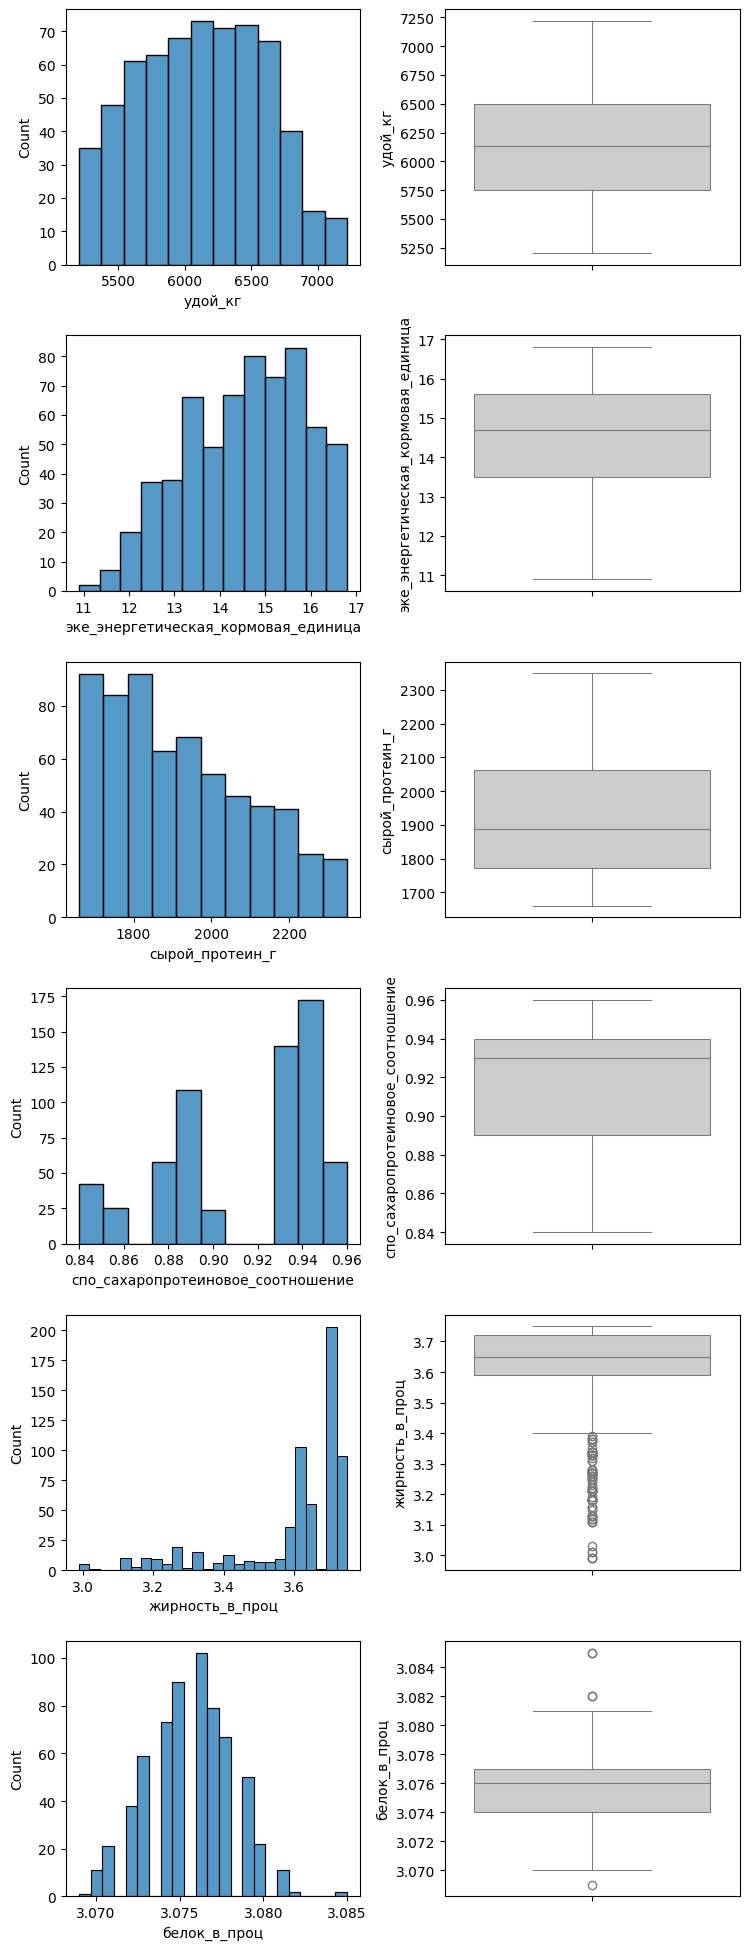

In [20]:
fig, axs = plt.subplots(6, 2, figsize=(8, 20))
fig.tight_layout(pad=3, h_pad=3)

for i, param in enumerate(quantitative):
    sns.boxplot(ferma_main[param], ax=axs[i, 1], color=".8", linewidth=.75, orient='v')
    sns.histplot(x=ferma_main[param], ax=axs[i, 0])

plt.show()

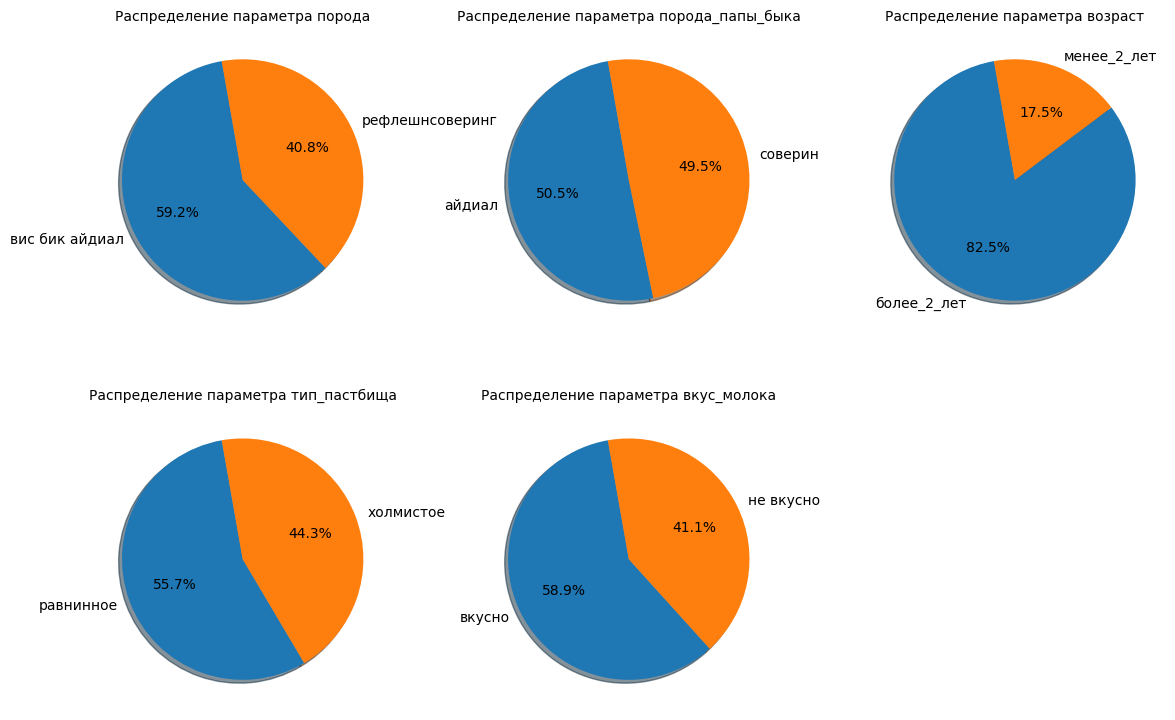

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.tight_layout(pad=3, h_pad=3)

for i, param in enumerate(categorical):
    ax = axs[i % 2, i // 2] 
    ax.pie(ferma_main[param].value_counts(), 
            shadow=True, 
            labels=ferma_main[param].unique(),
            startangle=100,
            autopct='%1.1f%%'
           )
    ax.set_title(f'Распределение параметра {param}', fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_xlabel('')
    axs[1, 2].set_visible(False)
plt.show()

Количественные характеристики распределены характерно. Распределений, протеворечащих здравому смыслу не выявлено. Статистические выбросы наблюдаются в колонках 'жирность_в_проц', 'белок_в_проц'. Средний удой равен 6133.

Качественные переменные распредены практически поровну, за искоючением параметра'возраст'. Большая часть голов старше 2 лет.

## Корреляционный анализ

Построим тепловую карту для матрицы коэффициентов корреляции.

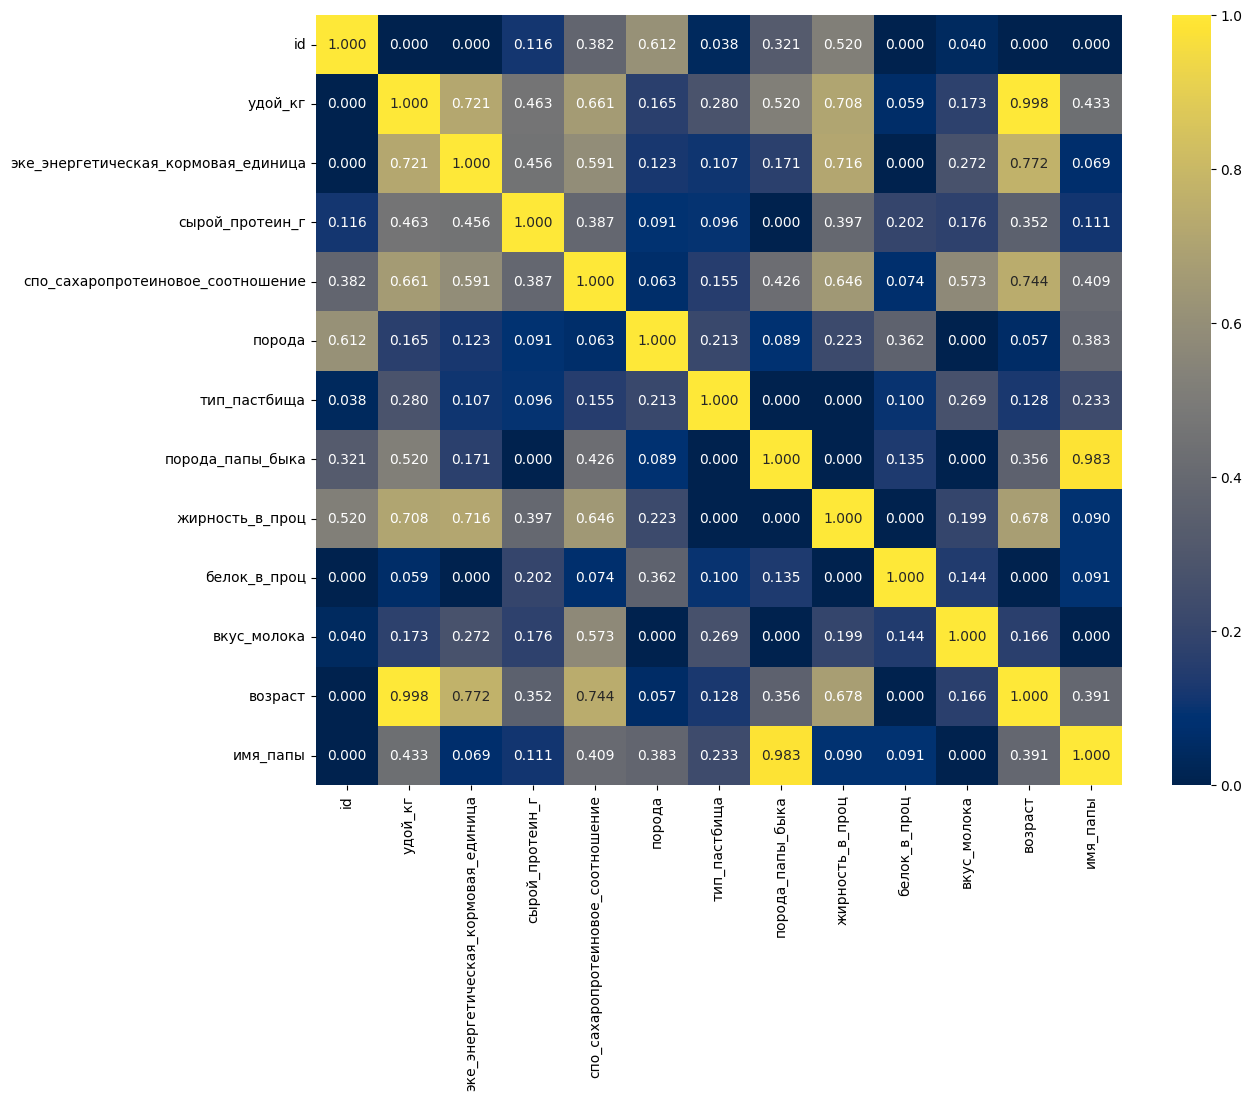

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(13, 10))
sns.heatmap(ferma_main.merge(ferma_dad, on='id').phik_matrix(interval_cols=quantitative+['id']), annot=True, cmap='cividis', fmt=".3f", ax=axs);
corr_heat_matrix = plt.gcf()

In [23]:
categorical, quantitative

(['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст'],
 ['удой_кг',
  'эке_энергетическая_кормовая_единица',
  'сырой_протеин_г',
  'спо_сахаропротеиновое_соотношение',
  'жирность_в_проц',
  'белок_в_проц'])

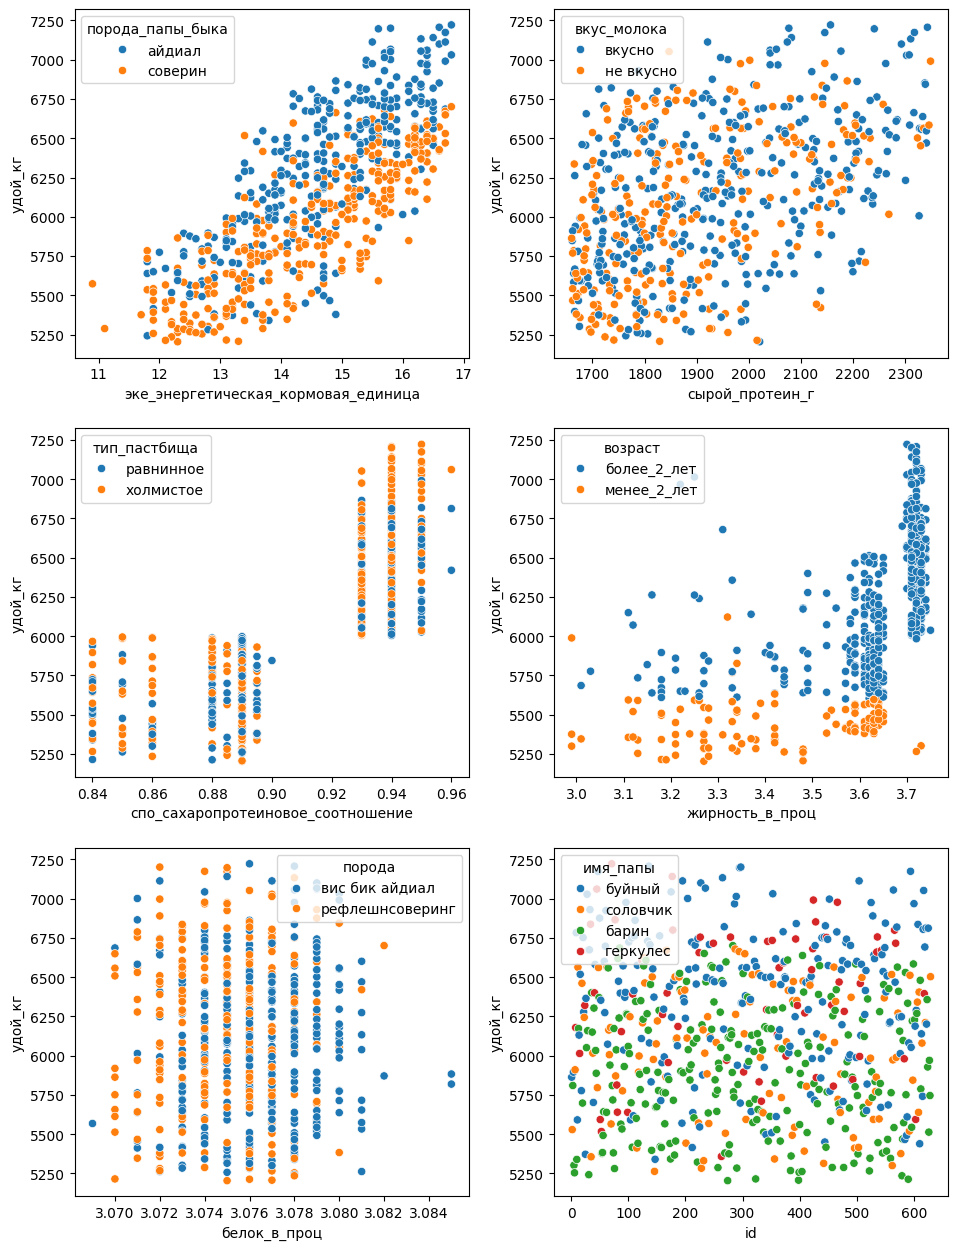

In [24]:
fig, axs = plt.subplots(3, 2, figsize=(10, 13))
plt.tight_layout(pad=3, h_pad=3)

sns.scatterplot(data=ferma_main, y='удой_кг', x='эке_энергетическая_кормовая_единица', hue='порода_папы_быка', ax=axs[0, 0])
sns.scatterplot(data=ferma_main, y='удой_кг', x='сырой_протеин_г', hue='вкус_молока', ax=axs[0, 1])
sns.scatterplot(data=ferma_main, y='удой_кг', x='спо_сахаропротеиновое_соотношение', hue='тип_пастбища', ax=axs[1, 0])
sns.scatterplot(data=ferma_main, y='удой_кг', x='жирность_в_проц', hue='возраст', ax=axs[1, 1])
sns.scatterplot(data=ferma_main, y='удой_кг', x='белок_в_проц', hue='порода', ax=axs[2, 0])
sns.scatterplot(data=ferma_main.merge(ferma_dad, on='id'), y='удой_кг', x='id', hue='имя_папы', ax=axs[2, 1])
# axs[2, 1].set_visible(False)

plt.show()

Наблюдая за графиками можно сделать несколько выводов:
1. Данные в большенстве своем распределены нелинейно. 
2. На величину удоя явно влияет возраст коровы и порода папы быка. Больше молока дают более взрослые коровы дают и потомки быка породы Айдиал.
3. При увеличении СПО - увеличивается удой коровы, но эта взимосвязь нелинейна.
4. Зависимость типа пастбища на удой коровы не выявлена.
5. Коровы далют молоко с разным содержанием белка в зависимости от породы.
6. Явная зависимость между именем папы и удоем не выявлена, однако, можно заметить, что потомки Буйного дают молока в среднем больше, чем потомки Барина. Опять же это может быть связано с тем, что одни просто старше других.
7. Наблюдается мультиколлинеарность между возрастом и удоем и между породой папы быка

По ходу проекта 2 основных целевых признака: вкус молока и удой.

## Обучение модели линейной регрессии

Перед обучением модели я уберу из датасета несколько признаков, таких как `"id", "вкус_молока"`.

По началу мне показалось, что убрать признаки `"жирность_в_проц" и "белок_в_проц"` было здоровой идеей, потому что неверно предсказывать сколько корова может дать молока по тому, какая жирность этого молока. Другое дело признаки, которые относятся к корове (тип пастбища, корма, родословной).

Но после углубления в тему, было выяснено, что по этим параметрам можно определять период лактации животного, который напрямую влияет на удой.

In [25]:
ferma_main.head()

,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаропротеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_в_проц,белок_в_проц,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,вис бик айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,вис бик айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,вис бик айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет


In [26]:
X1 = ferma_main.drop(columns=['вкус_молока', 'id', 'удой_кг'])
y1 = ferma_main['удой_кг']

In [27]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.25, random_state=RANDOM_STATE)

In [28]:
scaler_1, encoder_1, X_train_1, X_test_1 = data_X_coder(X_train_1, X_test_1)

In [29]:
model_lr_1 = LinearRegression()
model_lr_1.fit(X_train_1, y_train_1)
predictions_1 = model_lr_1.predict(X_test_1)

,Metric,Value
0,R2,0.815430
1,MAE,167.119826
2,MSE,43977.878364
3,RMSE,209.709033


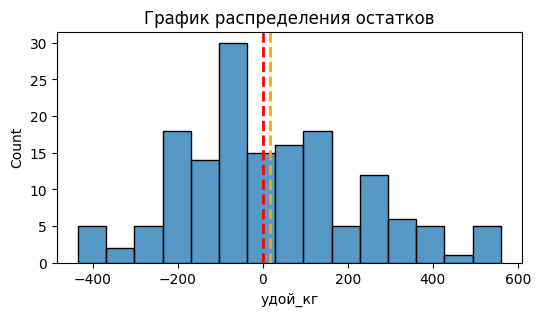

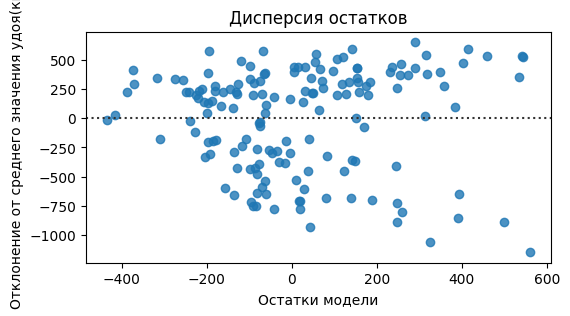

In [30]:
residuals_1, df_metric_1 = calculation_metrics(y_test_1, predictions_1)

На текущем этапе модель в 81,5 % случаев делает предсказание лучше, чем если бы выдавала среднее значание целевого признака. 
MAE и RMSE 167,11 и 209,7 литров соответственно. Остатки распределены нормально с отклонением влево. Это значит что модель немного занижает значения.

Для усиления линейной зависимости преобразуем СПО в категориальный признак, а ЭКЕ возведем в квадрат.

In [31]:
ferma = ferma_main.copy()

In [32]:
ferma['ЭКЕ'] = ferma['эке_энергетическая_кормовая_единица'] ** 2
ferma['СПО'] = ferma['спо_сахаропротеиновое_соотношение'].map(lambda x: 1 if x > 0.92 else 0)

In [33]:
ferma = ferma.drop(columns=['эке_энергетическая_кормовая_единица', 'спо_сахаропротеиновое_соотношение'])

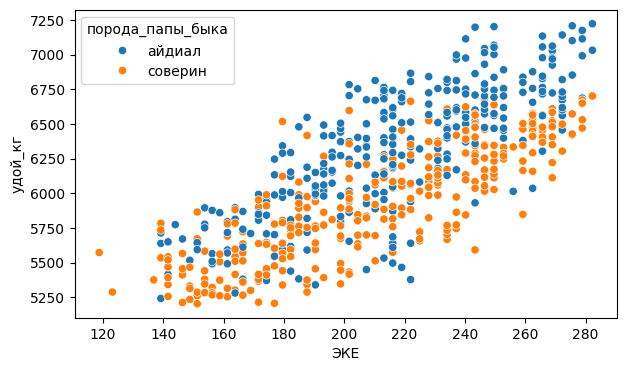

In [34]:
plt.figure(figsize=(7, 4))
sns.scatterplot(data=ferma, y='удой_кг', x='ЭКЕ', hue='порода_папы_быка');

In [35]:
X2 = ferma.drop(columns=['вкус_молока', 'id', 'удой_кг'])
y2 = ferma['удой_кг']

In [36]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.25, random_state=RANDOM_STATE)

In [37]:
scaler_2, encoder_2, X_train_2, X_test_2 = data_X_coder(X_train_2, X_test_2)

In [38]:
model_lr_2 = LinearRegression()
model_lr_2.fit(X_train_2, y_train_2)
predictions_2 = model_lr_2.predict(X_test_2)

,Metric,Value
0,R2,0.838117
1,MAE,156.104470
2,MSE,38572.084504
3,RMSE,196.397771


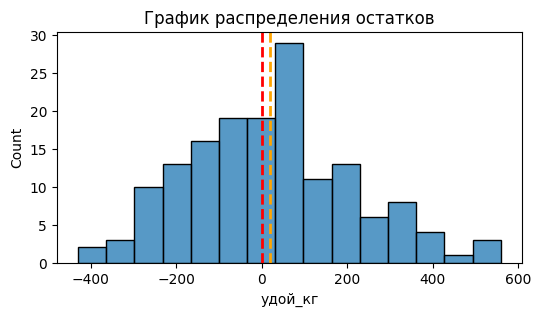

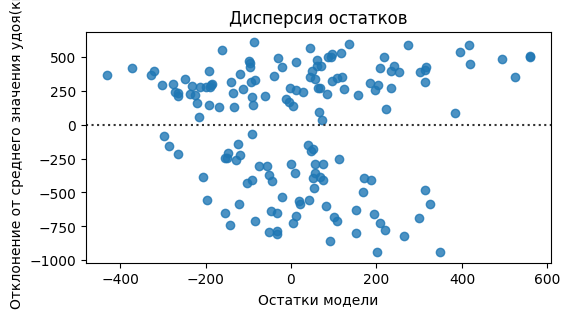

In [39]:
residuals_2, df_metric_2 = calculation_metrics(y_test_2, predictions_2)

Добавим еще один категориальный признак с именем папы коровы из датасета `ferma_dad.csv`. Попробуем признаки `"жирность_в_проц"` и `"белок_в_проц"` перевести в один параметр `"отношение_жира_к_белку"`. Такой параметр действительно используют в скотоводстве. Для улучшение зависимости, попробуем возвести значение в квадрат

In [40]:
ferma2 = ferma.merge(ferma_dad, on='id')

In [41]:
X3 = ferma2.drop(columns=['вкус_молока', 'id', 'удой_кг'])
y3 = ferma2['удой_кг']

In [42]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3, y3, test_size=0.25, random_state=RANDOM_STATE)

In [43]:
scaler_3, encoder_3, X_train_3, X_test_3 = data_X_coder(X_train_3, X_test_3)

In [44]:
model_lr_3 = LinearRegression()
model_lr_3.fit(X_train_3, y_train_3)
predictions_3 = model_lr_3.predict(X_test_3)

,Metric,Value
0,R2,0.853696
1,MAE,147.994499
2,MSE,34860.227991
3,RMSE,186.708939


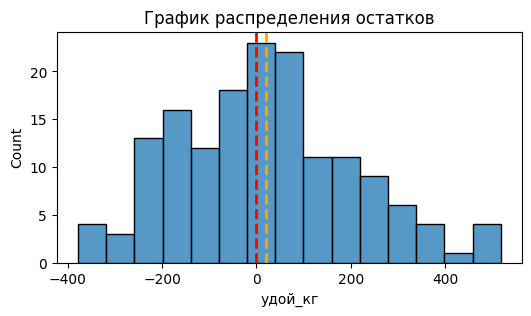

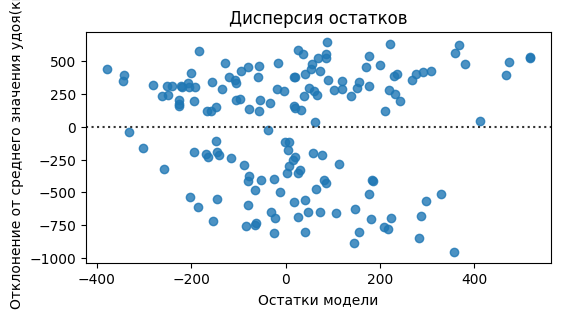

In [45]:
residuals_3, df_metric_3 = calculation_metrics(y_test_3, predictions_3)

В приведенной ниже таблице наглядно можно посмотреть как изменялись значения от модели №1 (Value_x) до модели №3 (Value)

In [46]:
metric_result = df_metric_1.merge(df_metric_2, on='Metric').merge(df_metric_3, on='Metric')
metric_result.columns = ['metric', 'model_1', 'model_2', 'model_3']
metric_result

,metric,model_1,model_2,model_3
0,R2,0.815430,0.838117,0.853696
1,MAE,167.119826,156.104470,147.994499
2,MSE,43977.878364,38572.084504,34860.227991
3,RMSE,209.709033,196.397771,186.708939


In [47]:
for feature_number, feature_name in enumerate(X_train_3.columns):
    weight = model_lr_3.coef_[feature_number]
    print(f"{feature_name:<20}: {weight:+.4f}")

порода_рефлешнсоверинг: +7.6888
тип_пастбища_холмистое: +54.9361
порода_папы_быка_соверин: +18.1593
возраст_менее_2_лет : -211.7430
имя_папы_буйный     : +264.9158
имя_папы_геркулес   : +272.4405
имя_папы_соловчик   : +41.0840
сырой_протеин_г     : +45.6927
жирность_в_проц     : +21.1866
белок_в_проц        : -17.2232
ЭКЕ                 : +145.7538
СПО                 : +178.1111


Коэффициент детерминации R2 вырос почти 3.5 % по сравнению с первоначальным вариантом, что означает что модель в 85.3% делает предсказание лучше, чем среднее. Средняя абсолютная ошибка уменьшилась на почти 17 литров с 167 до 150 литров, корень среднеквадратичной ошибки туменьшился на 21 литр до 188. 

Дисперсия остатков стала выглядеть равномернее, чем у первой модели, но еще очень далека от идеала. Она стала ближе к нулю, но модель все также делает более сильные ошибки, когда предсказывает большие значения.

In [48]:
lower_quantile = np.percentile(residuals_3, 2.5)
upper_quantile = np.percentile(residuals_3, 97.5)
print('Доверительный интервал модели в 95%:', lower_quantile, upper_quantile)

Доверительный интервал модели в 95%: -305.41876463116967 418.21063153738055


In [49]:
lower_quantile, upper_quantile

(-305.41876463116967, 418.21063153738055)



Теперь возьмемся за основную задачу: прогнозом удоя коров, которые фермер зочет купить. 

In [50]:
cow_buy_new = cow_buy.copy()

In [51]:
cow_buy_new['СПО'] = ferma_main['спо_сахаропротеиновое_соотношение'].mean()
cow_buy_new['СПО'] = cow_buy_new['СПО'].map(lambda x: 1 if x > 0.92 else 0)
cow_buy_new['ЭКЕ'] = (ferma_main['эке_энергетическая_кормовая_единица'].mean() * 1.05) ** 2
cow_buy_new['сырой_протеин_г'] = ferma_main['сырой_протеин_г'].mean() * 1.05

In [52]:
cow_buy_new = cow_buy_new.rename(columns={'текущая_жирность_в_проц':'жирность_в_проц', 'текущий_уровень_белок_в_проц':'белок_в_проц'})

In [53]:
cow_buy_new = cow_buy_new[X3.columns.to_list()]

In [54]:
cat_col_names, scaler_col_names = col_names(cow_buy_new)

In [55]:
cow_buy_new_ohe = encoder_3.transform(cow_buy_new[cat_col_names])

encoder_col_names = encoder_3.get_feature_names_out()

cow_buy_new_scaled = scaler_3.transform(cow_buy_new[scaler_col_names])
    
#объединяем разделенное
cow_buy_new_ohe = pd.DataFrame(cow_buy_new_ohe, columns=encoder_col_names)
cow_buy_new_scaled = pd.DataFrame(cow_buy_new_scaled, columns=scaler_col_names)

cow_buy_prepared = pd.concat([cow_buy_new_ohe, cow_buy_new_scaled], axis=1)

In [56]:
predictions = model_lr_3.predict(cow_buy_prepared)

In [57]:
cow_buy_new['prediction_удой'] = predictions

In [58]:
cow_buy_new.sort_values(by='prediction_удой', ascending=False).head(5)

,сырой_протеин_г,порода,тип_пастбища,порода_папы_быка,жирность_в_проц,белок_в_проц,возраст,ЭКЕ,СПО,имя_папы,prediction_удой
12,2019.947532,вис бик айдиал,холмистое,айдиал,3.68,3.046,более_2_лет,233.361138,0,геркулес,6415.394947
3,2019.947532,рефлешнсоверинг,холмистое,айдиал,3.40,3.061,более_2_лет,233.361138,0,буйный,6278.590942
15,2019.947532,рефлешнсоверинг,холмистое,айдиал,3.40,3.065,более_2_лет,233.361138,0,буйный,6251.605427
11,2019.947532,рефлешнсоверинг,равнинное,соверин,3.73,3.073,более_2_лет,233.361138,0,геркулес,6210.542625
0,2019.947532,вис бик айдиал,холмистое,айдиал,3.58,3.076,более_2_лет,233.361138,0,геркулес,6200.227732


Выше выведены топ-пять наиболее "производительных" коров из исходного списка.

## Обучение модели логистической регрессии

Для текущей модели логистический регрессии целевым признаком будет вкус молока, поэтоу тут нам и пригодятся признаки белка и жирности - они непременно должны влиять на вкус молока.

In [59]:
ferma = ferma_main.copy()
ferma['вкус_молока'] = ferma['вкус_молока'].map({'вкусно': 1, 'не вкусно': 0}).astype('int')

In [60]:
ferma['спо_сахаропротеиновое_соотношение'] = ferma['спо_сахаропротеиновое_соотношение'].map(lambda x: 1 if x > 0.92 else 0)
ferma['эке_энергетическая_кормовая_единица'] = ferma['эке_энергетическая_кормовая_единица'] ** 2

In [61]:
ferma.head()

,id,удой_кг,эке_энергетическая_кормовая_единица,сырой_протеин_г,спо_сахаропротеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_в_проц,белок_в_проц,вкус_молока,возраст
0,1,5863,201.64,1743,0,вис бик айдиал,равнинное,айдиал,3.58,3.076,1,более_2_лет
1,2,5529,163.84,2138,0,вис бик айдиал,равнинное,соверин,3.54,3.079,1,менее_2_лет
2,3,5810,196.00,1854,0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,0,более_2_лет
3,4,5895,153.76,2012,0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,0,более_2_лет
4,5,5302,163.84,1675,0,вис бик айдиал,равнинное,соверин,3.73,3.073,1,менее_2_лет


Вспомним тепловую карту признаков

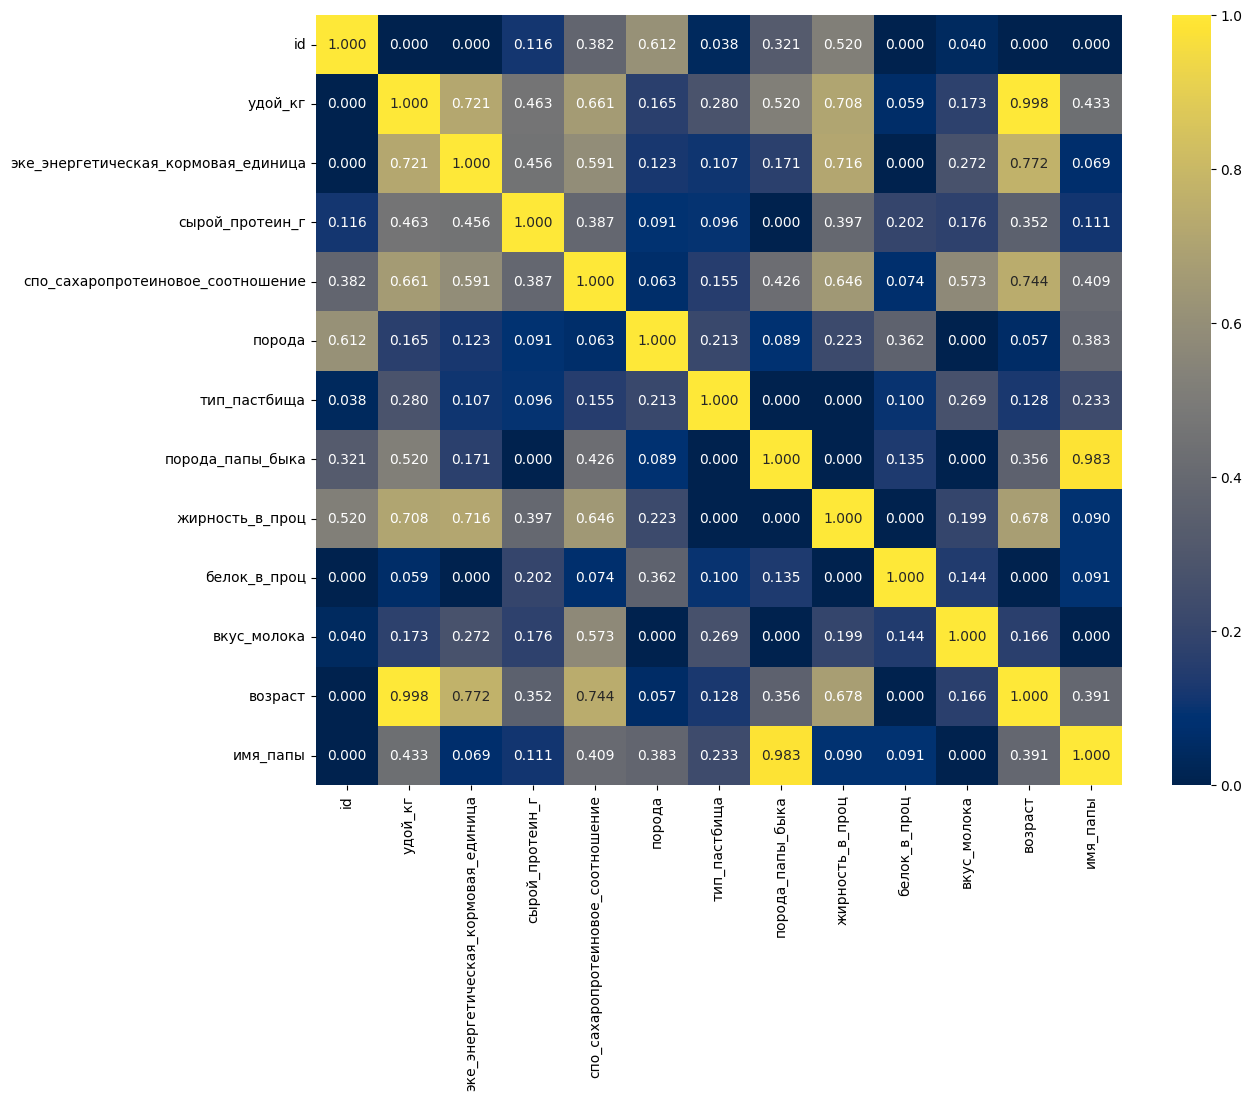

In [62]:
corr_heat_matrix

Здесь можно наблюдать отсутствие линейной зависимости между вкусом молока, породой коровы и породой папы быка. Эти признаки мы удалим.

In [63]:
X4 = ferma.drop(['id', 'вкус_молока', 'порода', 'порода_папы_быка', 'удой_кг'], axis=1)
y4 = ferma['вкус_молока']
X4 = X4.reindex(sorted(X4.columns), axis=1)

In [64]:
X_train_4, X_else, y_train_4, y_else = train_test_split(X4, y4, test_size=0.4, random_state=RANDOM_STATE)

In [65]:
X_valid_4, X_test_4, y_valid_4, y_test_4 = train_test_split(X_else, y_else, test_size=0.5, random_state=RANDOM_STATE)

In [66]:
scaler_4, encoder_4, X_train_4, X_valid_4, X_test_4 = data_X_coder(X_train_4, X_valid_4, X_test_4)

In [67]:
clf_1 = LogisticRegression()
clf_1 = clf_1.fit(X_train_4, y_train_4)

In [68]:
accuracy_score(y_train_4, clf_1.predict(X_train_4))

0.6569148936170213

Точность текущей модели - 65%. Посредственный результат. Или может вкус молока слишком субъективный фактор...

Даже визуально сложно выявить какую-либо зависимость чего-либо от куса молока

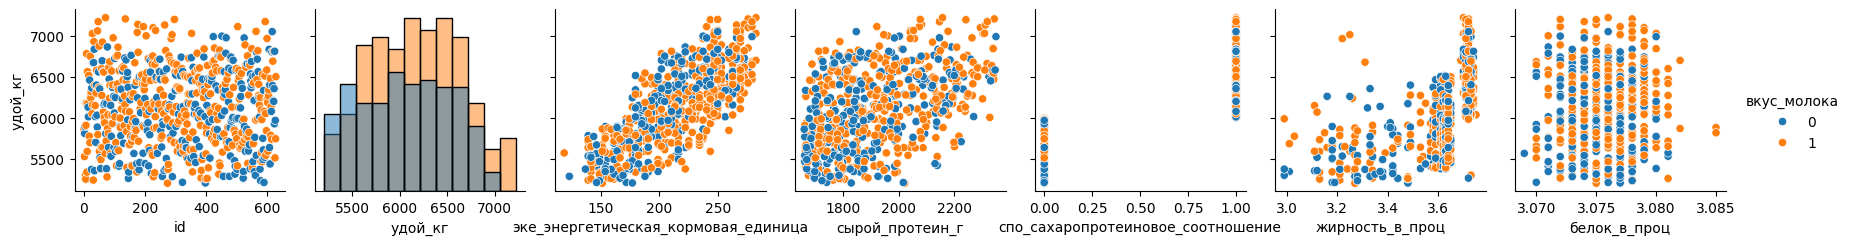

In [69]:
g = sns.PairGrid(ferma, hue='вкус_молока', y_vars='удой_кг')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

In [70]:
for feature_number, feature_name in enumerate(X_train_4.columns):
    weight = clf_1.coef_[0, feature_number]
    print(f"{feature_name:<20}: {weight:+.4f}")

возраст_менее_2_лет : -0.4458
тип_пастбища_холмистое: +0.5740
белок_в_проц        : +0.2709
жирность_в_проц     : -0.1549
спо_сахаропротеиновое_соотношение: -0.3376
сырой_протеин_г     : +0.0166
эке_энергетическая_кормовая_единица: +0.7840


Наибольшие веса имеют признаки ЭКЕ и типа паситбища

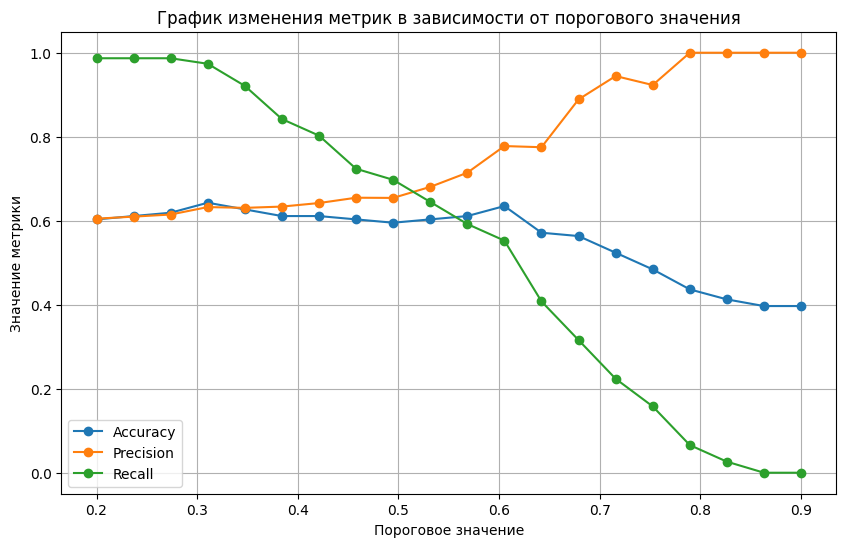

Ниже приведена табличная расшифровка графика


,0.200000,0.236842,0.273684,0.310526,0.347368,0.384211,0.421053,0.457895,0.494737,0.531579,0.568421,0.605263,0.642105,0.678947,0.715789,0.752632,0.789474,0.826316,0.863158,0.900000
acc,0.603175,0.611111,0.619048,0.642857,0.626984,0.611111,0.611111,0.603175,0.595238,0.603175,0.611111,0.634921,0.571429,0.563492,0.523810,0.484127,0.436508,0.412698,0.396825,0.396825
pres,0.604839,0.609756,0.614754,0.632479,0.630631,0.633663,0.642105,0.654762,0.654321,0.680556,0.714286,0.777778,0.775000,0.888889,0.944444,0.923077,1.000000,1.000000,1.000000,1.000000
rec,0.986842,0.986842,0.986842,0.973684,0.921053,0.842105,0.802632,0.723684,0.697368,0.644737,0.592105,0.552632,0.407895,0.315789,0.223684,0.157895,0.065789,0.026316,0.000000,0.000000
thresholds,0.200000,0.236842,0.273684,0.310526,0.347368,0.384211,0.421053,0.457895,0.494737,0.531579,0.568421,0.605263,0.642105,0.678947,0.715789,0.752632,0.789474,0.826316,0.863158,0.900000


In [71]:
logistic_regression_metrics(clf_1, X_valid_4, y_valid_4)

Наиболее важная метрика в нашем случая это precision (ошибка первого рода), так как нам важно, чтобы корова точно давала вкусное молоко и на каждую неверно поставленную единицу фермер может понести убытки. Порговое значение threshold, при котором метрика precision достигнет максимальной величины на валидационной выборке - 0,76. 

Да, из-за того что модель имеет довольно низкую точность, объем поставленных единиц тренировочной около 15 процентов от общего истинного их количества, зато в каждой из них можно быть уверенным.

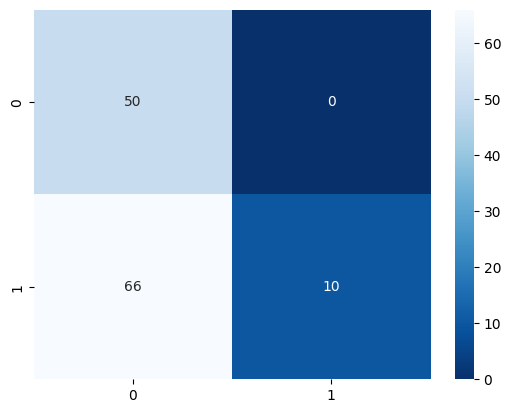

In [72]:
proba = clf_1.predict_proba(X_valid_4)
cnm = confusion_matrix(y_valid_4, proba[:, 1] > 0.765)
sns.heatmap(cnm, annot=True, fmt='d', cmap='Blues_r');

На валидационной выборке precision достигает максимума и исключает ошибку первого рода при пороговом значении 0,76. На тестовой выборке этот порог выше - 84. Возьмем среднее значение равное 80, поскольку иначе "вкусного" молока может не оказаться совсем.

Теперь попробуем применить обученную модель к данным «ЭкоФермы».

In [73]:
cow_buy_taste = cow_buy.copy().drop(['имя_папы', 'порода', 'порода_папы_быка'],  axis=1)

cow_buy_taste['спо_сахаропротеиновое_соотношение'] = 0
cow_buy_taste['эке_энергетическая_кормовая_единица'] = (ferma_main['эке_энергетическая_кормовая_единица'].mean() * 1.05) ** 2
cow_buy_taste['сырой_протеин_г'] = ferma_main['сырой_протеин_г'].mean() * 1.05

cow_buy_taste.rename(columns={'текущая_жирность_в_проц':'жирность_в_проц', 'текущий_уровень_белок_в_проц':'белок_в_проц'}, inplace=True)

cow_buy_taste = cow_buy_taste.reindex(sorted(cow_buy_taste.columns), axis=1)

In [74]:
cat_col_names, scaler_col_names = col_names(cow_buy_taste)

In [75]:
cow_buy_taste_ohe = encoder_4.transform(cow_buy_taste[cat_col_names])

encoder_col_names = encoder_4.get_feature_names_out()

cow_buy_taste_scaled = scaler_4.transform(cow_buy_taste[scaler_col_names])

cow_buy_taste_ohe = pd.DataFrame(cow_buy_taste_ohe, columns=encoder_col_names)
cow_buy_taste_scaled = pd.DataFrame(cow_buy_taste_scaled, columns=scaler_col_names)

cow_buy_prepared = pd.concat([cow_buy_taste_scaled, cow_buy_taste_ohe], axis=1)

cow_buy_prepared = cow_buy_prepared[X_train_4.columns]

In [76]:
y_taste_pred = clf_1.predict(cow_buy_prepared)

y_taste_proba = clf_1.predict_proba(cow_buy_prepared)

In [77]:
cow_buy_new['predict_вкус_молока_80'] = pd.Series(y_taste_proba[:, 1]).map(lambda x: 1 if x >= 0.80 else 0)

In [78]:
cow_buy_new['predict_вкус_молока_68'] = pd.Series(y_taste_proba[:, 1]).map(lambda x: 1 if x >= 0.68 else 0)
cow_buy_new['predict_вкус_молока_65'] = pd.Series(y_taste_proba[:, 1]).map(lambda x: 1 if x >= 0.65 else 0)

In [79]:
cow_buy_result = cow_buy_new.drop(['сырой_протеин_г', 'ЭКЕ', 'СПО'], axis=1) \
                            .sort_values(by=['predict_вкус_молока_80', 'prediction_удой'], ascending=False) \
                            .query("prediction_удой >= 6000 and predict_вкус_молока_80 == 1")
cow_buy_result_else = cow_buy_new.drop(['сырой_протеин_г', 'ЭКЕ', 'СПО'], axis=1) \
                            .sort_values(by=['predict_вкус_молока_68', 'prediction_удой'], ascending=False) \
                            .query("prediction_удой >= 6000 and predict_вкус_молока_65 == 1")
cow_buy_result

,порода,тип_пастбища,порода_папы_быка,жирность_в_проц,белок_в_проц,возраст,имя_папы,prediction_удой,predict_вкус_молока_80,predict_вкус_молока_68,predict_вкус_молока_65
0,вис бик айдиал,холмистое,айдиал,3.58,3.076,более_2_лет,геркулес,6200.227732,1,1,1
6,вис бик айдиал,холмистое,айдиал,3.58,3.076,более_2_лет,геркулес,6200.227732,1,1,1


Критерием отбора для фермера является удой более 6000 килограммов в год и вкусное молоко. Таких коров оказалось только 2 штуки - не густо, всего 10% от общего количества.

## Итоговые выводы

В ходе работы были исследованы данные, предоставленные фермером молочного хозяйства «Вольный луг», который хочет купить бурёнок, чтобы расширить поголовье стада коров. Пропусков данных не было обнаружено, удалены явные и исправлены неявные дубликаты.

Ходе обучения моделей линейной регрессии была обучена первая модель линейной регресси на иисходных данных таблицы ferma_main, после во второй модели были преобразованы данные признаков СПО в категориальный ЭКЕ возведена квадрат. Третья модель обучена с добавлением дополнительного признака имени папы быка. Результаты метрик трех моделей приведены ниже.

In [80]:
metric_result

,metric,model_1,model_2,model_3
0,R2,0.815430,0.838117,0.853696
1,MAE,167.119826,156.104470,147.994499
2,MSE,43977.878364,38572.084504,34860.227991
3,RMSE,209.709033,196.397771,186.708939


Для предсказания данных об удое была выбрана модель №3. Ниже приведены ТОП-5 коров по величине удоя за год.

In [81]:
cow_buy_new.sort_values(by='prediction_удой', ascending=False).head(5)

,сырой_протеин_г,порода,тип_пастбища,порода_папы_быка,жирность_в_проц,белок_в_проц,возраст,ЭКЕ,СПО,имя_папы,prediction_удой,predict_вкус_молока_80,predict_вкус_молока_68,predict_вкус_молока_65
12,2019.947532,вис бик айдиал,холмистое,айдиал,3.68,3.046,более_2_лет,233.361138,0,геркулес,6415.394947,0,0,0
3,2019.947532,рефлешнсоверинг,холмистое,айдиал,3.40,3.061,более_2_лет,233.361138,0,буйный,6278.590942,0,0,0
15,2019.947532,рефлешнсоверинг,холмистое,айдиал,3.40,3.065,более_2_лет,233.361138,0,буйный,6251.605427,0,0,0
11,2019.947532,рефлешнсоверинг,равнинное,соверин,3.73,3.073,более_2_лет,233.361138,0,геркулес,6210.542625,0,0,0
0,2019.947532,вис бик айдиал,холмистое,айдиал,3.58,3.076,более_2_лет,233.361138,0,геркулес,6200.227732,1,1,1


Для предсказания вкуса была обучена модель логистической регрессии. В данном случае в качестве основной метрики была выбрана precision для минимизации ошибок первого рода. Ничего страшного если модель не учтет корову с потенциально вкусным молоком, гораздо хуже если будет много ложно позитивных значений, в результате чего фермер купит корову, ее молоко окажется не вкусным, в следствие чего он потерпит убытки.

Перед предсказанием в таблицу cow_buy были добавлены недостающие признаки, увеличенные на 5%, модифицированные аналогичено второй модели линейной регресси. Точность модели оставляла желать лучшего, получилось так, скорее всего, из-за того что входные признаки имели слабую взаимосвязь с целевым. В таком случае стоило бы поискать чуть больше данных, которые бы сильнее коррелировали со вкусом молока.

Порогом классификации было выбрано значение 0.80. 

При после предсказания данных и их фильтрации в соответствиями с критериями заказщика было выбрано 2 коровы, которые удовлетваряли необходимым требованиям. Эта покупка с минимальным риском.

In [82]:
cow_buy_result

,порода,тип_пастбища,порода_папы_быка,жирность_в_проц,белок_в_проц,возраст,имя_папы,prediction_удой,predict_вкус_молока_80,predict_вкус_молока_68,predict_вкус_молока_65
0,вис бик айдиал,холмистое,айдиал,3.58,3.076,более_2_лет,геркулес,6200.227732,1,1,1
6,вис бик айдиал,холмистое,айдиал,3.58,3.076,более_2_лет,геркулес,6200.227732,1,1,1


Если заказчик в некоторой cтепени допускает риск, то я бы оставил порог классиификации в 0.68 - это величина, при котором значение всех метрик для нашего случая оптимальное. Так получится выбрать больше коров. На валидационной выборке:
1. Accuracy - 0.55
2. Precision - 0.91
3. Recall - 0.29

Да, риск больше, но и потенциальных коров, которые можно купить, которые могу принести потенциальную прибыль в 1.5 раза больше. Можно еще снизить порог до 0.65, тогла коров будет 5.

In [83]:
cow_buy_result_else

,порода,тип_пастбища,порода_папы_быка,жирность_в_проц,белок_в_проц,возраст,имя_папы,prediction_удой,predict_вкус_молока_80,predict_вкус_молока_68,predict_вкус_молока_65
0,вис бик айдиал,холмистое,айдиал,3.58,3.076,более_2_лет,геркулес,6200.227732,1,1,1
6,вис бик айдиал,холмистое,айдиал,3.58,3.076,более_2_лет,геркулес,6200.227732,1,1,1
7,вис бик айдиал,равнинное,соверин,3.57,3.079,более_2_лет,буйный,6134.409438,0,1,1
4,рефлешнсоверинг,равнинное,айдиал,3.64,3.074,более_2_лет,буйный,6166.613967,0,0,1
19,рефлешнсоверинг,равнинное,айдиал,3.64,3.074,более_2_лет,буйный,6166.613967,0,0,1
